# Twitter Data Project

Group Members: Zan Xie (UID: 205364923), Joseph Gong (UID: 606073799), Anuk Fernando (UID: 805423707)

In [91]:
# library import
from google.colab import drive
drive.mount('/content/drive')

import json
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt

# text cleaning
import pytz
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

# feature extraction
import pytz
import pandas as pd
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# baseline model
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# LSTM model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#Q9.1

In [2]:
# hashtag summary function

folder_path = '/content/drive/Shareddrives/ECE219/Project4/twitter_data/'
tweet_file = ['tweets_#gohawks.txt', 'tweets_#gopatriots.txt', 'tweets_#nfl.txt', 'tweets_#patriots.txt', 'tweets_#sb49.txt', 'tweets_#superbowl.txt']
tweet_hashtag = ['#gohawks', '#gopatriots', '#nfl', '#patriots', '#sb49', '#superbowl']

# open hashtag file, return tweet summary
def hashtag_summary(file_name):
  # initi variables
  time_list = []
  tweet_total = 0
  follower_total = 0
  retweet_total = 0

  with open(folder_path + file_name, 'r') as file:
    for line in file:
      json_object = json.loads(line)
      tweet_total += 1
      follower_total += json_object['author']['followers']
      retweet_total += json_object['metrics']['citations']['total']
      unix_time = json_object['citation_date']
      time_list.append(unix_time)
    file.close()

  # total hours
  time_start = min(time_list)
  time_end = max(time_list)
  time_total = (time_end - time_start) / 3600

  # summary
  tweet_avg = tweet_total / time_total
  follower_avg = follower_total / tweet_total
  retweet_avg = retweet_total / tweet_total

  return tweet_avg, follower_avg, retweet_avg


In [ ]:
# implement
# run time 5 mins
for file_name, hashtag_name in zip(tweet_file, tweet_hashtag):
  # iterate over hashtag files
  tweet_avg, follower_avg, retweet_avg = hashtag_summary(file_name)
  print('Given hashtag:', hashtag_name)
  print('Average number of tweets per hour:', tweet_avg)
  print('Average number of followers of users posting the tweets per tweet:', follower_avg)
  print('Average number of retweets per tweet:', retweet_avg)
  print('-'*20)


Given hashtag: #gohawks
Average number of tweets per hour: 292.48785062173687
Average number of followers of users posting the tweets per tweet: 2217.9237355281984
Average number of retweets per tweet: 2.0132093991319877
--------------------
Given hashtag: #gopatriots
Average number of tweets per hour: 40.95469800606194
Average number of followers of users posting the tweets per tweet: 1427.2526051635405
Average number of retweets per tweet: 1.4081919101697078
--------------------
Given hashtag: #nfl
Average number of tweets per hour: 397.0213901819841
Average number of followers of users posting the tweets per tweet: 4662.37544523693
Average number of retweets per tweet: 1.5344602655543254
--------------------
Given hashtag: #patriots
Average number of tweets per hour: 750.89426460689
Average number of followers of users posting the tweets per tweet: 3280.4635616550277
Average number of retweets per tweet: 1.7852871288476946
--------------------
Given hashtag: #sb49
Average number of 

#Q9.2

In [3]:
# Plot “number of tweets in hour” over time for #SuperBowl and #NFL

def tweet_in_hour(file_name):
  # initi variables
  time_list = []
  tweets_per_hour = defaultdict(int)

  with open(folder_path + file_name, 'r') as file:
    for line in file:
      json_object = json.loads(line)
      unix_time = json_object['citation_date']
      # reserve only hour information
      dt = datetime.datetime.fromtimestamp(unix_time).replace(minute=0, second=0, microsecond=0)
      unix_time = int(dt.timestamp())
      time_list.append(unix_time)
    file.close()

  # get the earliest unix_time for reference
  time_start = min(time_list)
  datetime_start = datetime.datetime.fromtimestamp(time_start)

  # tweets time with respect to the reference
  time_list_ref = [((x - time_start) / 3600) for x in time_list]
  for item in time_list_ref:
    tweets_per_hour[item] += 1

  return tweets_per_hour, str(datetime_start)


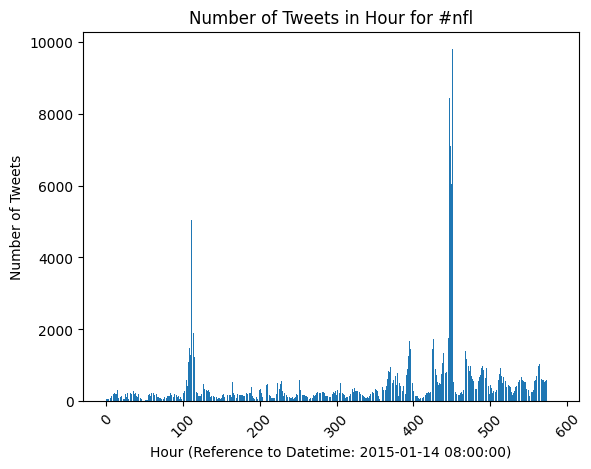

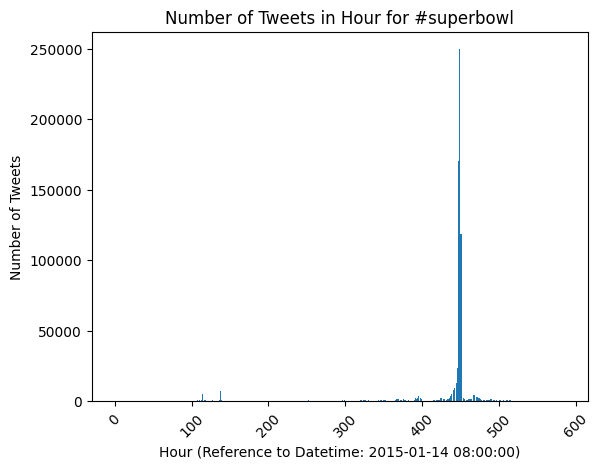

In [ ]:
# Plot nfl and superbowl

compare_file = ['tweets_#nfl.txt', 'tweets_#superbowl.txt']
compare_hashtag = ['#nfl', '#superbowl']

for file_name, hashtag_name in zip(compare_file, compare_hashtag):
  tweets_per_hour, datetime_start = tweet_in_hour(file_name)

  plt.bar(tweets_per_hour.keys(), tweets_per_hour.values())
  plt.xlabel(f'Hour (Reference to Datetime: {datetime_start})')
  plt.ylabel('Number of Tweets')
  plt.title(f'Number of Tweets in Hour for {hashtag_name}')
  plt.xticks(rotation=45)
  plt.show()
  print('\n')


#Q10

# Time-Series Correlation between Scores and Tweets

# Task Description

We analyze a dataset of tweets with timestamps to correlate them with football game scores over time, in this case, the Super Bowl. The aim is to create a model that, given a tweet, can predict the team that is currently winning or potentially the score.

# Feature Engineering Process

1. Dataset: Randomly select 12138 samples from #superbowl file which has 1213813 samples. Construct a dataframe with corresponding datetime in PST time zone, follower_count, and retweet_count. Truncate the original dataset is helpful in reducing process overhead.
2. Text Preprocess: Clean and lemmatize tweets_title. Then, apply sentiment analysis on lemm_clean_text.
3. Sentiment Analysis: TextBlob and VADER(SentimentIntensityAnalyzer) are common tools for the purpose. I chose VADER since VADER is specifically designed for sentiment analysis in social media texts.
4. Advanced Text Representation: Beyond TF-IDF, consider using word embeddings like GloVe. These can capture semantic relationships between words better.


In [4]:
# time zone
pst_tz = pytz.timezone('America/Los_Angeles')

# data path
folder_path = '/content/drive/Shareddrives/ECE219/Project4/twitter_data/'
tweet_file = ['tweets_#gohawks.txt', 'tweets_#gopatriots.txt', 'tweets_#nfl.txt', 'tweets_#patriots.txt', 'tweets_#sb49.txt', 'tweets_#superbowl.txt']
tweet_hashtag = ['#gohawks', '#gopatriots', '#nfl', '#patriots', '#sb49', '#superbowl']
superbowl_file_path = folder_path + tweet_file[5]

# retrive data feaurs
with open(superbowl_file_path, 'r') as f:
  line = f.readline()
  json_object = json.loads(line)
  data_features = list(json_object.keys())
  f.close()

print(data_features)

# Print the content of each feature
print("\nContents of each feature:")
for feature in data_features:
    print(f"{feature}: {json_object[feature]}")

['firstpost_date', 'title', 'url', 'tweet', 'author', 'original_author', 'citation_date', 'metrics', 'highlight', 'type', 'citation_url']

Contents of each feature:
firstpost_date: 1419883838
title: At http://t.co/Vd0RWOeAed -- #Seahawks #12thMAN #12 #SeahawkNation #SuperBowlBound #Superbowl #Repeat #GoHawks ... http://t.co/XSEFUKqEhN
url: http://twitter.com/HawksNationYes/status/549658771749101568
tweet: {'contributors': None, 'truncated': False, 'text': 'At http://t.co/Vd0RWOeAed -- #Seahawks #12thMAN #12 #SeahawkNation #SuperBowlBound #Superbowl #Repeat #GoHawks ... http://t.co/XSEFUKqEhN', 'in_reply_to_status_id': None, 'id': 549658771749101568, 'favorite_count': 0, 'source': '<a href="http://ifttt.com" rel="nofollow">IFTTT</a>', 'retweeted': False, 'coordinates': None, 'timestamp_ms': '1419883838008', 'entities': {'symbols': [], 'media': [{'expanded_url': 'http://twitter.com/HawksNationYes/status/549658771749101568/photo/1', 'sizes': {'large': {'h': 640, 'resize': 'fit', 'w': 640}

In [5]:
# GloVe Word Embedding
def load_glove_embeddings(glove_file):
  embeddings_dict = {}
  with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector
  return embeddings_dict

# loading the 300-dimensional GloVe embeddings
glove_embeddings = load_glove_embeddings('/content/drive/Shareddrives/ECE219/Project4/GloVe/glove.6B.300d.txt')

# Ensure this dictionary is passed to the function correctly
def text_to_embedding(text, embeddings_dict):
  words = text.split()  # Assuming text is already preprocessed and space-separated
  embeddings = [embeddings_dict.get(word, np.zeros(300)) for word in words]  # Adjust 100 to your GloVe dimension
  if embeddings:
    return np.mean(embeddings, axis=0)
  else:
    return np.zeros(300)  # Adjust 100 to match your GloVe dimension

In [6]:
# text cleaning process
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

def clean(text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  texter = re.sub(r'\d+', '', texter) # exclude numbers
  texter = re.sub('[^a-zA-Z0-9\n]', ' ', texter) # Replace characters A-Za-z0-9 and decimal
  texter = re.sub('\s+',' ', texter) # Removing whitespace and newlines
  texter = texter.lower() # convert to lower case
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
      texter = ""
  return texter

#lemmatization
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


In [188]:
# tweets dataframe and save to file
# skip this step if the file has beeen saved
# read dataframe in the next code block

# initialize variables
title_list = []
time_list = []
follower_list = []
retweet_list = []
af_list = []
len_title_list = []
unix_time_list = []

# user post count
tweet_file = open(superbowl_file_path, 'r')
user_counts = {}
for line in tweet_file:
  json_object = json.loads(line)
  author = json_object['author']['name']
  if author in user_counts:
    user_counts[author] += 1
  else:
    user_counts[author] = 1

with open(superbowl_file_path, 'r') as f:
  for line in f:
    json_object = json.loads(line)
    title = json_object['title']
    follower = json_object['author']['followers']
    retweet = json_object['metrics']['citations']['total']
    unix_time = json_object['citation_date']
    datatime = datetime.datetime.fromtimestamp(unix_time, pst_tz)
    author = json_object['author']['name']
    len_title = len(title.split())

    # construct dataframe wrt current tweet
    title_list.append(title)
    time_list.append(datatime)
    follower_list.append(follower)
    retweet_list.append(retweet)
    af_list.append(user_counts[author])
    len_title_list.append(len_title)
    unix_time_list.append(unix_time)
  f.close()

# construct the dataframe
df_tweets = pd.DataFrame({
    'title': title_list,
    'unix time': unix_time_list,
    'timestamp': time_list,
    'follower_count': follower_list,
    'retweet_count': retweet_list,
    'active factor': af_list,
    'length title': len_title_list
})

# save the dataframe to file
df_tweets.to_pickle('/content/drive/Shareddrives/ECE219/Project4/tweet_saved_file/df_tweet.pkl')


In [7]:
# read the dataframe
df_tweets = pd.read_pickle('/content/drive/Shareddrives/ECE219/Project4/tweet_saved_file/df_tweet.pkl')

# Print the first few rows of the DataFrame
display(df_tweets)

,title,unix time,timestamp,follower_count,retweet_count,active factor,length title
0,At http://t.co/Vd0RWOeAed -- #Seahawks #12thMA...,1421468497,2015-01-16 20:21:37-08:00,22.0,2,2,13
1,You been 12ed pass it on #SeahawkNation #LOB #...,1421467579,2015-01-16 20:06:19-08:00,22.0,15,2,14
2,27 days to the SuperBowl 🏈🏈\n#Katyperry #KatyC...,1421266957,2015-01-14 12:22:37-08:00,858.0,2,1,12
3,Check out the cool event that #budlight has p...,1421261298,2015-01-14 10:48:18-08:00,14335.0,2,1,14
4,Lenny Kravitz acompañará a Katy Perry en el #H...,1421316031,2015-01-15 02:00:31-08:00,1143.0,7,1,12
...,...,...,...,...,...,...,...
1213808,Look at this crazy map of all the private jets...,1423328580,2015-02-07 09:03:00-08:00,297.0,1,38,19
1213809,Where to start making money online for beginne...,1423330066,2015-02-07 09:27:46-08:00,1759.0,1,46,13
1213810,Still in superbowl mode 🏈🏈🏈\n#SB49 #superbowl ...,1423330744,2015-02-07 09:39:04-08:00,69827.0,5,13,13
1213811,"@pscgt2015 Nice, Debbie! @futieton #SB49 #phx ...",1423331367,2015-02-07 09:49:27-08:00,1085.0,1,3,9


In [8]:
# Scoring events
# if New England Patriots winning, label=1
# if Seattle Seahawks winning, label=0
# if even score, whoever wins that score goes to his label
# default score label=0, since Seattle Seahawks is the 'home' team

# Game start time, year-month-day-hour-min, time_zone
game_start = pst_tz.localize(datetime.datetime(2015, 2, 1, 15, 30))

# Function to calculate event time
def event_time(quarter, minutes, seconds):
    quarter_lengths = 15  # 15 minutes per quarter
    elapsed_since_start = datetime.timedelta(minutes=(quarter - 1) * quarter_lengths)
    time_to_event = datetime.timedelta(minutes=(quarter_lengths - minutes), seconds=(60 - seconds))
    event_datetime = game_start + elapsed_since_start + time_to_event
    return event_datetime

scoring_data = [
    (event_time(2, 9, 47), "New England Patriots", "7-0", 1),
    (event_time(2, 2, 16), "Seattle Seahawks", "7-7", 0),
    (event_time(2, 0, 31), "New England Patriots", "14-7", 1),
    (event_time(2, 0, 2), "Seattle Seahawks", "14-14", 0),
    (event_time(3, 11, 9), "Seattle Seahawks", "14-17", 0),
    (event_time(3, 4, 54), "Seattle Seahawks", "14-24", 0),
    (event_time(4, 7, 55), "New England Patriots", "21-24", 0),
    (event_time(4, 2, 2), "New England Patriots", "28-24", 1),
]

# Create DataFrame
df_scoring = pd.DataFrame(scoring_data, columns=['Event Time', 'Scoring Team', 'Score', 'Winning Label'])
print(df_scoring)


                 Event Time          Scoring Team  Score  Winning Label
0 2015-02-01 15:51:13-08:00  New England Patriots    7-0              1
1 2015-02-01 15:58:44-08:00      Seattle Seahawks    7-7              0
2 2015-02-01 16:00:29-08:00  New England Patriots   14-7              1
3 2015-02-01 16:00:58-08:00      Seattle Seahawks  14-14              0
4 2015-02-01 16:04:51-08:00      Seattle Seahawks  14-17              0
5 2015-02-01 16:11:06-08:00      Seattle Seahawks  14-24              0
6 2015-02-01 16:23:05-08:00  New England Patriots  21-24              0
7 2015-02-01 16:28:58-08:00  New England Patriots  28-24              1


In [9]:
# truncate the dataset down to 12138 samples (100 times less samples)
# initialize empty columns for sentiment score and winning label

df_tweets_select = df_tweets.sample(n=12138, random_state=42)
df_tweets_select = df_tweets_select.sort_index()
df_tweets_select['clean text'] = None
df_tweets_select['sentiment score'] = None
df_tweets_select['winning label'] = None
sia = SentimentIntensityAnalyzer()

# Iterate through the df_tweets_select DataFrame
for i, row in df_tweets_select.iterrows():
  # Filter df_scoring to include events before the post's timestamp
  relevant_events = df_scoring[df_scoring['Event Time'] <= row['timestamp']]

  # clean text and sentiment score
  clean_text = clean(row['title'])
  lemm_clean_text = lemmatize_sentence(clean_text)
  sentiment_socre = sia.polarity_scores(lemm_clean_text)

  # The most recent scoring event append to dataframe
  if relevant_events.empty:
    df_tweets_select.at[i, 'winning label'] = 0
  else:
    recent_event = relevant_events.iloc[-1]
    df_tweets_select.at[i, 'winning label'] = int(recent_event['Winning Label'])

  df_tweets_select.at[i, 'sentiment score'] = sentiment_socre['compound']
  df_tweets_select.at[i, 'clean text'] = lemm_clean_text

# print the selected tweet dataframe
display(df_tweets_select)


,title,unix time,timestamp,follower_count,retweet_count,active factor,length title,clean text,sentiment score,winning label
31,Just a #SuperBowlChampion #Pedestrian wide re...,1421224793,2015-01-14 00:39:53-08:00,142.0,1,6,11,just a superbowlchampion pedestrian wide recei...,0.0,0
276,Gotta love that the entire city of #Seattle is...,1421261323,2015-01-14 10:48:43-08:00,4310.0,1,4,17,get ta love that the entire city of seattle be...,0.8442,0
386,"RT @liquidityinc: This might be ingenious, @cj...",1421269215,2015-01-14 13:00:15-08:00,11420.0,1,1,16,rt liquidityinc this might be ingenious cjwehl...,0.0,0
472,"During #SB49, block on 1 St. b/w Jefferson &am...",1421275030,2015-01-14 14:37:10-08:00,515.0,2,10,21,during sb block on st b w jefferson and washin...,-0.4404,0
535,Impress your #SuperBowlXLIX guests and enjoy w...,1421282326,2015-01-14 16:38:46-08:00,3995.0,2,3,15,impress your superbowlxlix guest and enjoy wat...,0.7096,0
...,...,...,...,...,...,...,...,...,...,...
1213483,Omg 😌😍😍 @5SOS #SuperBowl http://t.co/ldsVSI7ncv,1423286621,2015-02-06 21:23:41-08:00,2414.0,1,1,5,omg so superbowl http t co ldsvsincv,0.0,1
1213607,✌️🏉 #tevejonavic #letsclub #superbowl #katyper...,1423289803,2015-02-06 22:16:43-08:00,481.0,1,41,7,tevejonavic letsclub superbowl katyperry darkh...,0.0,1
1213696,.@MissyElliott cried tears of joy after her #S...,1423293311,2015-02-06 23:15:11-08:00,599655.0,15,6,10,missyelliott cry tear of joy after her superbo...,0.1779,1
1213750,#superbowl #seahawks #12thman Get your Superbo...,1423294785,2015-02-06 23:39:45-08:00,2916.0,1,163,9,superbowl seahawks thman get your superbowl sh...,0.0,1


# Baselines

Baseline models should be simple yet relevant. For this task, a logistic regression classifier could serve as a good baseline for binary classification.

Evaluation: A Logistic Regression Classifier is trained to serve as the baseline mode, and a dummy Logistic Regression Classifier is also trained for the purpose of comparison. Two classifiers' evaluation is shown below. Focus on model accuracy, the Losgistic Regression model reach to 0.680 while the dummy classifer is only 0.570. It suports the idea that the baseline logistic model has ability to predict winning team, even though it might not be at a super high acurracy.

In [61]:
# Evaluation function

def eval_model(model, X_test_svd, Y_test_label, y_pred, roc_idx):
  #svc_disp = metrics.RocCurveDisplay.from_estimator(model, X_test_svd, Y_test_label) # ROC curve
  cm = metrics.confusion_matrix(Y_test_label, y_pred) # Confusion matrix
  acc = metrics.accuracy_score(Y_test_label, y_pred) # Accuracy
  recall = metrics.recall_score(Y_test_label, y_pred) # Recall
  precision = metrics.precision_score(Y_test_label, y_pred) # Precision
  f1 = metrics.f1_score(Y_test_label, y_pred) # F-1 score

  # AUC curve with more decimal digits
  if (roc_idx):
    y_pred_proba = model.predict_proba(X_test_svd)[::,1]
    fpr, tpr, _ = metrics.roc_curve(Y_test_label,  y_pred_proba)
    auc = metrics.roc_auc_score(Y_test_label, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

  #plt.show()
  print('Consufion Matrxi:')
  print(cm)
  print("Accuracy:", acc)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F-1 score:", f1)


In [12]:
# Logistic Regression Model
# Prepare dataset and labels

X = df_tweets_select[['clean text', 'retweet_count', 'active factor', 'sentiment score']]
y = df_tweets_select['winning label']
y = y.astype(int)

# GloVe Word Embedding
text_embedding = X['clean text'].apply(lambda x: text_to_embedding(x, glove_embeddings))
expanded_text_embedding = text_embedding.apply(pd.Series)
expanded_text_embedding.columns = ['Feature_' + str(i) for i in range(1, len(expanded_text_embedding.columns) + 1)]

# reconstruct dataframe with GloVe Word Embedding
X = X.drop('clean text', axis=1)
X = pd.concat([X, expanded_text_embedding], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # shuffle=False for time series data

# Logistic Regression
# Initialize a Logistic Regression classifier and fit it to the training data
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Initialize a dummy classifier to always predict the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)


Logistic Regression Classifier Report


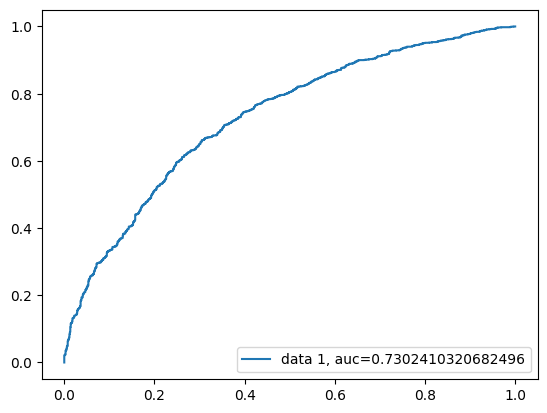

Consufion Matrxi:
[[ 568  481]
 [ 297 1082]]
Accuracy: 0.6795716639209226
Recall: 0.7846265409717187
Precision: 0.6922584772872681
F-1 score: 0.7355540448674373


Dummy Classifier Report


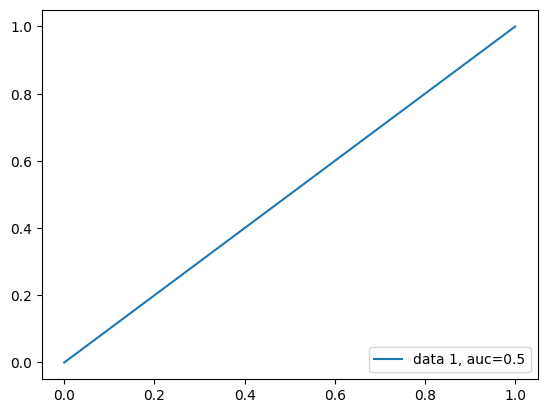

Consufion Matrxi:
[[   0 1049]
 [   0 1379]]
Accuracy: 0.5679571663920923
Recall: 1.0
Precision: 0.5679571663920923
F-1 score: 0.7244549514053059


In [13]:
# Evaluate the Logistic Regression classifier
print("Logistic Regression Classifier Report")
eval_model(logreg, X_test, y_test, y_pred_logreg, 1)
print('\n')

# Evaluate the dummy classifier
print("Dummy Classifier Report")
eval_model(dummy_clf, X_test, y_test, y_pred_dummy, 1)


# Advanced Machine Learning Model


Shifting towards deep learning models, especially for tasks involving natural language processing (NLP), can significantly enhance the ability to model and understand complex relationships and patterns in text data. Given your dataset and the use of GloVe embeddings, an LSTM (Long Short-Term Memory) model is a good starting point for exploring deep learning techniques. LSTMs are effective at capturing long-term dependencies in sequence data, making them well-suited for text analysis tasks.

Evaluation: The LSTM model reaches an accuracy of 0.678 which shows little difference from the baseline logistic model. By oberserving Epoch training steps, the accuracy increase and loss decrease as step, indicating that the model is performing as expected. However, the accuracy is not high enough to beat the baseline model.

In [90]:
# LSTM evaluation function

def eval_model_LSTM(model, X_test, Y_test_label, y_pred, roc_idx, y_pred_proba=None):
  cm = metrics.confusion_matrix(Y_test_label, y_pred)
  acc = metrics.accuracy_score(Y_test_label, y_pred)
  recall = metrics.recall_score(Y_test_label, y_pred)
  precision = metrics.precision_score(Y_test_label, y_pred)
  f1 = metrics.f1_score(Y_test_label, y_pred)

  if roc_idx and y_pred_proba is not None:
    fpr, tpr, _ = metrics.roc_curve(Y_test_label,  y_pred_proba)
    auc = metrics.roc_auc_score(Y_test_label, y_pred_proba)
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.legend(loc=4)
    plt.show()

  print('Confusion Matrix:')
  print(cm)
  print("Accuracy:", acc)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F-1 score:", f1)

In [94]:
# LSTM model
# Convert pandas DataFrames to numpy arrays
X_train_np = X_train.values.astype('float32')
y_train_np = y_train.values.astype('float32').reshape(-1, 1)  # Reshaping if y_train is a single column DataFrame
X_test_np = X_test.values.astype('float32')
y_test_np = y_test.values.astype('float32').reshape(-1, 1)  # Reshaping if y_test is a single column DataFrame

# reshape dataset
X_train_reshaped = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
X_test_reshaped = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))

# construct model
model = Sequential([
    # Assuming each feature is a sequential step, adding Conv1D for feature extraction
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),  # Flatten the convolution output before feeding into dense layers
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Define learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

# Compile the model with the new learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback and fit model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train_np, y_train_np, batch_size=64, epochs=30, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.5644 - loss: 0.7132 - val_accuracy: 0.6097 - val_loss: 0.6651
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.5999 - loss: 0.6693 - val_accuracy: 0.6406 - val_loss: 0.6365
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.6269 - loss: 0.6499 - val_accuracy: 0.6519 - val_loss: 0.6285
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.6515 - loss: 0.6338 - val_accuracy: 0.6416 - val_loss: 0.6261
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.6527 - loss: 0.6204 - val_accuracy: 0.6395 - val_loss: 0.6285
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.6791 - loss: 0.6102 - val_accuracy: 0.6468 - val_loss: 0.6169
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.6714 - loss: 0.6046 - val_accuracy: 0.6529 - val_loss: 0.6180
Epoch 8/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.6877 - loss: 0.5836 

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


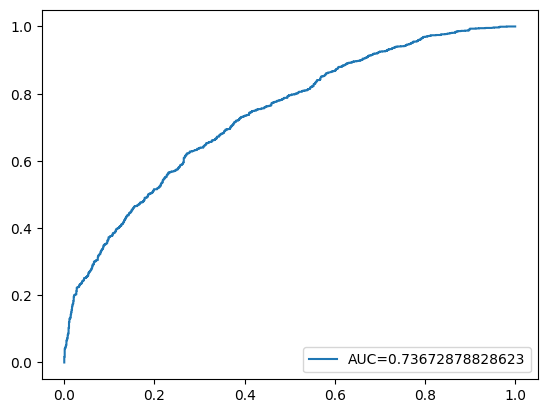

Confusion Matrix:
[[ 528  521]
 [ 285 1094]]
Accuracy: 0.6680395387149918
Recall: 0.7933284989122552
Precision: 0.6773993808049535
F-1 score: 0.7307949231796926


In [95]:
# Generate probabilities
y_pred_proba = model.predict(X_test_np).flatten()

# Convert probabilities to binary predictions (0 or 1) based on a 0.5 threshold
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# evaluate performance
eval_model_LSTM(model, X_test_np, y_test_np, y_pred_binary, roc_idx=1, y_pred_proba=y_pred_proba)

# Evaluation

Compare performance of the baseline Logistic Model and LSTM model.

1. Accuracy
Logistic Regression: 67.96%
LSTM: 66.80%
Analysis: The logistic regression model has a slightly higher accuracy compared to the LSTM model. Accuracy measures the overall correctness of the model across both classes but doesn't provide insight into the model's performance on individual classes.

2. Recall
Logistic Regression: 78.46%
LSTM: 79.33%
Analysis: Both models have similar recall scores, with the LSTM model slightly outperforming the logistic regression model. Recall measures the model's ability to correctly identify positive instances. A higher recall indicates fewer false negatives. The similar recall scores suggest both models are comparably effective at identifying positive instances.

3. Precision
Logistic Regression: 69.23%
LSTM: 67.74%
Analysis: The logistic regression model has a higher precision than the LSTM model. Precision measures the proportion of true positive predictions in all positive predictions made by the model. A higher precision indicates fewer false positives. The logistic regression model is slightly better at ensuring its positive predictions are correct.

4. F-1 Score
Logistic Regression: 73.56%
LSTM: 73.08%
Analysis: The F-1 score is a harmonic mean of precision and recall, providing a single metric to assess the balance between them. The logistic regression model has a marginally higher F-1 score, suggesting a better balance between precision and recall compared to the LSTM model.

5. Overall Evaluation and Analysis
The logistic regression model slightly outperforms the LSTM model across most metrics, with notable differences in precision and overall accuracy.

The reason that LSTM model did not perform outstandingly compare to the baseline logistic model can be that
1. Feature Extraction: The features extracted from original features might not be curical enough for LSTM model to achieve a better performance.
2. Model Parameters: Both models' performance can significantly depend on the choice of hyperparameters. The LSTM model might require more extensive hyperparameter tuning to optimize its architecture and training process for the specific task.
3. Model Complexity: LSTM might work better with a more complex model, comparing to the setup I used.